| Parameter    | Units                 | Physical Role                                        |
|--------------|-----------------------|------------------------------------------------------|
| $$ \mu $$    | $$\text{Pa}\cdot\text{s}$$ | Dynamic viscosity of blood                           |
| $$ k_t $$    | $$ \text{m}^2 $$      | 3D tissue permeability                               |
| $$ k_v $$    | $$ \text{m}^2 $$      | Axial permeability along the vessel                  |
| $$ \gamma $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Vessel wall permeability coefficient (coupling tissue & vessel) |
| $$ \gamma_R $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Boundary outflow (Robin) permeability                 |
| $$ \gamma_a $$ | $$\text{m}$$                    | Terminal vessel coupling length scale (hydraulic conductance at end) |

In [1]:
%%capture
!pip install numpy==1.26.4
!pip install ipywidgets vtk meshio pyvista Rtree

In [1]:
import sys, os, importlib

WORK_PATH = "/root/3d-1d"
MODULES_PATH = os.path.join(WORK_PATH, 'modules')

sys.path.append(MODULES_PATH)

In [2]:
from graphnics import FenicsGraph

TEST_GRAPH_NODES = {
    0: [0.000, 0.020, 0.015],   # A
    1: [0.010, 0.020, 0.015],   # B
    2: [0.022, 0.013, 0.015],   # C
    3: [0.022, 0.028, 0.015],   # D
    4: [0.015, 0.005, 0.015],   # E
    5: [0.015, 0.035, 0.015],   # F
    6: [0.038, 0.005, 0.015],   # G
    7: [0.038, 0.035, 0.015]    # H
}

TEST_GRAPH_EDGES = [
    (0, 1, 0.004),  # AB
    (1, 2, 0.003),  # BC
    (1, 3, 0.003),  # BD
    (2, 4, 0.002),  # CE
    (2, 6, 0.003),  # CG
    (3, 5, 0.002),  # DF
    (3, 7, 0.003)   # DH
]

TEST_GRAPH = FenicsGraph()

for node, pos in TEST_GRAPH_NODES.items():
    TEST_GRAPH.add_node(node, pos=pos)

for u, v, radius in TEST_GRAPH_EDGES:
    TEST_GRAPH.add_edge(u, v, radius=radius)

/usr/local/lib/python3.11/dist-packages/block/__init__.py:15: UserWarning: The cbc.block repository has moved to https://github.com/blocknics/cbc.block
  warnings.warn('The cbc.block repository has moved to https://github.com/blocknics/cbc.block', UserWarning)


Missing HsMG for fract norm computing


In [18]:
import FEMSinkVelo
importlib.reload(FEMSinkVelo)

VTEST = FEMSinkVelo.FEMSinkVelo(
    G = TEST_GRAPH,
    gamma = 100,
    gamma_R = 1.0e-5,
    gamma_v = 1.0e-5,
    gamma_a = 1.0e-5,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 1.5e-11, # Vessel permeability in 1D
    P_in = 100.0 * 133.322, # 100 mmHg
    p_cvp = 1.0 * 133.322, # 1 mmHg
    Lambda_inlet = [0]
)

Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1498.03it/s]


Applied BC! Non-empty list


Node Pressure Data:
Node 0: Pressure 13332.2
Node 113: Pressure 13131.8
Node 57: Pressure 12912.7
Node 114: Pressure 12684.4
Node 29: Pressure 12432.0
Node 116: Pressure 12179.4
Node 58: Pressure 11926.6
Node 115: Pressure 11646.8
Node 15: Pressure 11258.8
Node 119: Pressure 10870.4
Node 60: Pressure 10482.0
Node 120: Pressure 10095.6
Node 30: Pressure 9713.3
Node 118: Pressure 9328.4
Node 59: Pressure 8988.8
Node 117: Pressure 8677.7
Node 8: Pressure 8366.8
Node 125: Pressure 8056.4
Node 63: Pressure 7793.7
Node 126: Pressure 7603.0
Node 32: Pressure 7412.3
Node 128: Pressure 7221.4
Node 64: Pressure 7029.2
Node 127: Pressure 6831.0
Node 16: Pressure 6633.0
Node 123: Pressure 6448.1
Node 62: Pressure 6267.2
Node 124: Pressure 6086.5
Node 31: Pressure 5905.6
Node 122: Pressure 5752.3
Node 61: Pressure 5617.2
Node 121: Pressure 5481.8
Node 1: Pressure 5346.6
Node 145: Pressure 5162.1
Node 73: Pressure 4986.1
Node 146: Pressure 4836.4
Node 37: Pressure 4698.3
Node 148: Pressure 4560.3
No

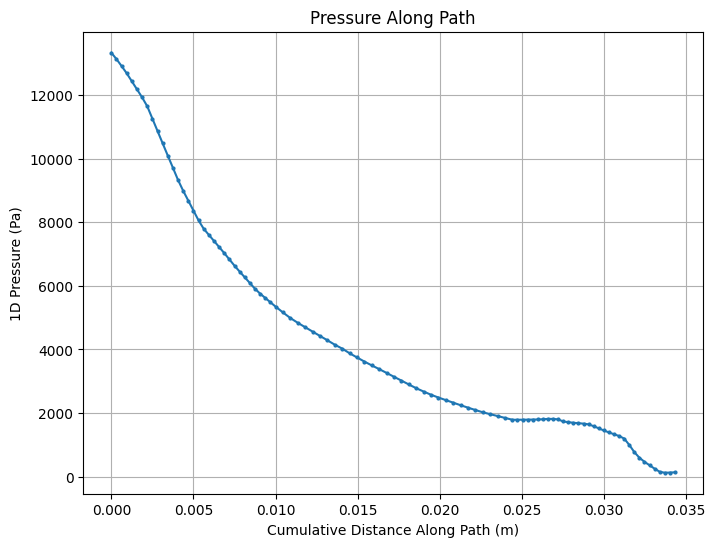

In [19]:
import Visualizer
importlib.reload(Visualizer)
Visualizer.plot_path_pressure(VTEST.uh1d, TEST_GRAPH, [0, 1, 3, 5])

In [26]:
import FEMSinkCubeFlux
import numpy as np
importlib.reload(FEMSinkCubeFlux)

CUBE_TEST = FEMSinkCubeFlux.FEMSinkCubeFlux(
    G = TEST_GRAPH,
    gamma = 1.0e-5,
    gamma_R = 1.0e-5,
    gamma_v = 1.0e-5,
    gamma_a = 1.0e-5,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 1.5e-11, # Vessel permeability in 1D
    P_in = 100.0 * 133.322, # 100 mmHg
    p_cvp = 1.0 * 133.322, # 1 mmHg
    Lambda_inlet = [0],
    upper_cube_bounds = [np.array(TEST_GRAPH_NODES[0]) - np.array([0.005, 0.005, 0.005]), np.array(TEST_GRAPH_NODES[0]) + np.array([0.005, 0.005, 0.005])]
)

Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1744.70it/s]


Applied BC! Non-empty list


Lower Cube Bounds: [[-0.008, -0.003, 0.006999999999999999], [0.0, 0.005, 0.015]]
Upper Cube Bounds: [array([-0.005,  0.015,  0.01 ]), array([0.005, 0.025, 0.02 ])]


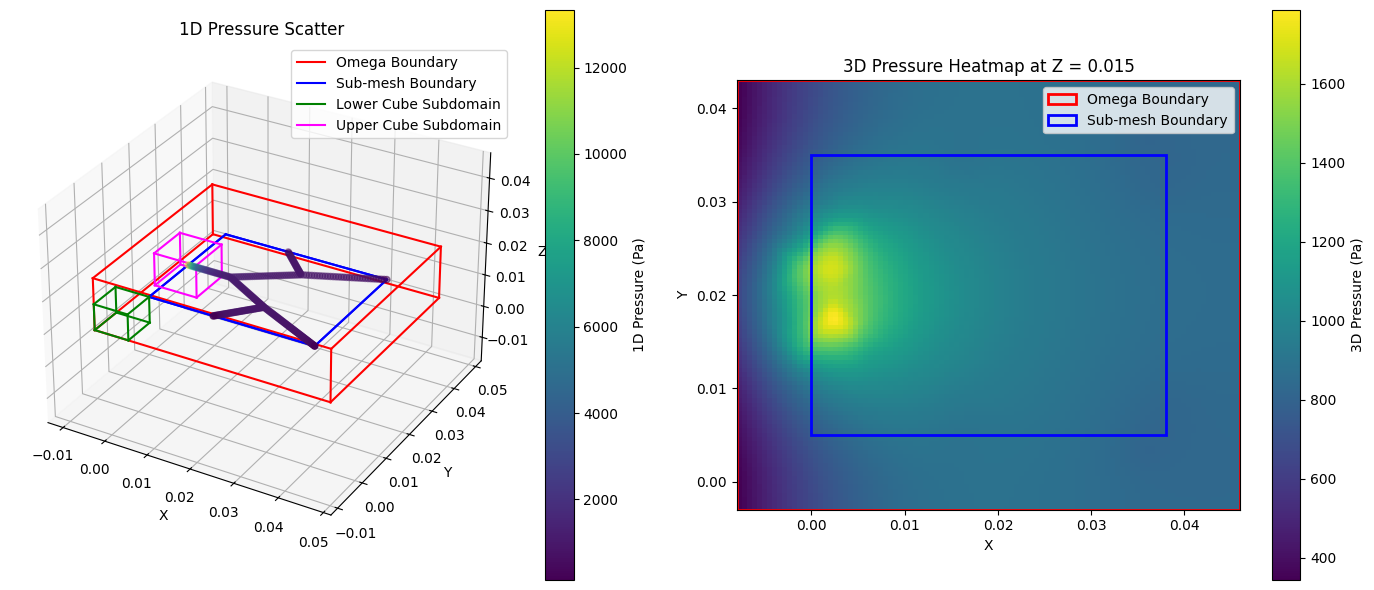

In [27]:
importlib.reload(Visualizer)
cube_lower_bounds = CUBE_TEST.lower_cube_bounds
cube_upper_bounds = CUBE_TEST.upper_cube_bounds

print("Lower Cube Bounds:", cube_lower_bounds)
print("Upper Cube Bounds:", cube_upper_bounds)

Visualizer.plot_with_boundaries(CUBE_TEST.uh1d, CUBE_TEST.uh3d,
     cube_lower=cube_lower_bounds, 
     cube_upper=cube_upper_bounds)

In [28]:
CUBE_TEST.compute_upper_cube_flux()

0.0

In [14]:
import datetime

now = datetime.datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
filename = f"output_{timestamp}.vtk"

SAVE_PATH = os.path.join(WORK_PATH, "export", filename)
CUBE_TEST.save_vtk(SAVE_PATH)